# Self-Driving Car Engineer Nanodegree

## Project: Vehicle Detection and Tracking

This notebook is my attempt at Project #5. The goal of this project is to write a software pipeline to dentify vehicles in a video from a front-facing camera on a car. 

# MOST OF CODE SHOWN BELOW IS TAKEN FROM THE LECTURE AND QUIZES

In [1]:
#**************************************************************************
############################################################################################################################################
#STEP 0: IMPORT ALL OF THE USEFUL PACKAGES
import numpy as np
import cv2
import csv
import os
import time
import collections
import imageio
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
imageio.plugins.ffmpeg.download()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


---

## Step 1: Create the Dataset, Label, and Load

This is to label the data we were give as 'cars' or 'not-cars'.

In [2]:
###########################################################################################################
#STEP 1: CREATE DATASET AND LABEL
#This opens a data.csv file that I created and adds the given examples of 'cars' and 'not-cars' to it
data_file = open("data.csv", 'w', newline='') #open the CSV I want to write to
writer = csv.writer(data_file)

for dirpath, dirnames, filenames in os.walk("vehicles"): #label all of the vehicle images 1
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 1])

for dirpath, dirnames, filenames in os.walk("non-vehicles"): #label all of the non-vehicle images 0
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 0])

###########################################################################################################
#STEP 1.5: LOAD THE DATASET
#This loads and splits my data into useable arrays
#array to hold the csv excel files created
lines = [] 

#open the data that was collected and store in lines
with open("data.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#arrays to store the image and their label
images = []
carOrNots = []

#load images and labels to arrays
for line in lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    images.append(image)
    carOrNot = line[1]
    carOrNots.append(carOrNot)

#split up the data, use random in case I want to play with different training sets/is this a bad idea/
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(images, carOrNots, test_size=0.2, random_state=rand_state) 

#see how the split went
y_traincounts = collections.Counter(y_train)
y_testcounts = collections.Counter(y_test)

print(y_traincounts)
print(y_testcounts)

Counter({'1': 7030, '0': 7019})
Counter({'1': 1762, '0': 1751})


## Step 2: Choose and Train Colorspace and SVM. 

This is to pick a colorspace for my hog features to use. Just going to pick the best one after a few runs. Also, once I have a color space in place, I will do the same for an SVM (Linear or RBF probably). 

In [3]:
###########################################################################################################
#STEP 2: TRAIN THE SVM

#Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
colorspace = 'YCrCb'

# Define a function to return HOG features and visualization
def get_hog_features_train(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images, for gray change to 0
def extract_features_train(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = file
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb': #change to gray
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) #cv2.COLOR_BGR2YGRAY, 
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features_train(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features_train(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


t=time.time() #just to see how long all of this takes

X_trainHogs = extract_features_train(X_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel) #getting features for my training data
X_testHogs = extract_features_train(X_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel) #getting features for my test data

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...') #how long it took to train

X = X_trainHogs
Xtester = X_testHogs
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
X_scalertest = StandardScaler().fit(Xtester)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_Xtest = X_scalertest.transform(Xtester)

# Define the labels vector
y = y_train
ytest = y_test

X_trained = scaled_X
X_tested = scaled_Xtest

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_trained[0]))
# Use a linear SVC or RBF
svc = SVC(C=10)#LinearSVC(C=1) #Change this to test
# Check the trainig time for the SVC
t=time.time()
svc.fit(X_trained, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_tested, ytest), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_tested[0:n_predict]))
print('For these',n_predict, 'labels: ', ytest[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

53.21 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
178.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9943
My SVC predicts:  ['1' '0' '1' '0' '1' '1' '1' '1' '1' '1']
For these 10 labels:  ['1', '0', '1', '0', '1', '1', '1', '1', '1', '1']
0.1426 Seconds to predict 10 labels with SVC



## Step 3: Create Pipeline Functions and Classes

Create the functions and classes that my pipleline will use.

In [4]:
#Pipeline Functions
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(img, orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
        # Call get_hog_features() with vis=False, feature_vec=True
    hog_features2 = []
    for channel in range(img.shape[2]):
        hog_features2.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, feature_vec=True))
    hog_features2 = np.ravel(hog_features2)        
        # Append the new feature vector to the features list
    # Return list of feature vectors
    return hog_features2

def search_windows(img, windows, clf, scaler, orient, pix_per_cell, cell_per_block, feature_vec=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        test_img2 = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCrCb)
        #4) Extract features for that window using single_img_features()
        HOGfeatures = extract_features(test_img2, orient, pix_per_cell, cell_per_block)
        #5) Scale extracted features to be fed to classifier
        # Fit a per-column scaler
        #X_scaler2 = StandardScaler().fit(HOGfeatures)
        # Apply the scaler to X
        test_features = scaler.transform(np.array(HOGfeatures).reshape(1, -1))#X_scaler2.transform(HOGfeatures)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == '1':
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        height = bbox[1][1] - bbox[0][1]
        width = bbox[1][0] - bbox[0][0]
        #print(height, width)
        if height > 50  and width > 50:
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6) #was drawing small boxes everywhere
    # Return the image
    return img

In [5]:
#class to create windows for the search
class Windows():
    
    def __init__(self):
        self.windowssmall = []
        self.windowsmed = []
        self.windowslarge = []
        self.windows = []
        
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    def createWindows(self, image):
    
        self.windowssmall = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                        xy_window=(72, 72), xy_overlap=(.8, .8))

        self.windowsmed = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                        xy_window=(128, 96), xy_overlap=(.75, .75))

        self.windowslarge = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                        xy_window=(160, 128), xy_overlap=(.65, .65))

        return  self.windowssmall + self.windowsmed + self.windowslarge


In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

class movingAvg():
    def __init__(self, img, moves=100):
        self.heatAvgs = np.zeros((img.shape[0],img.shape[1],moves))
        
    def giveMeHeatAvg(self, heatmap):
        self.heatAvgs = self.heatAvgs[:,:,1:] #slices the last piece off
        self.heatAvgs = np.dstack((self.heatAvgs, heatmap)) #adds another heatmap
        return np.average(self.heatAvgs, axis=2)



## Step 4: The Pipeline

The pipeline an image will flow through to find vehicles on the road.

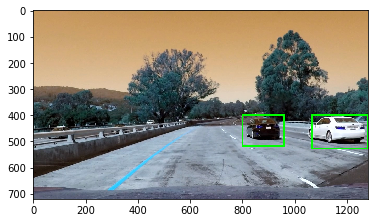

In [7]:
windows = Windows()
imagewindow = cv2.imread('test_images/test1.jpg')
windowsSearch = windows.createWindows(imagewindow)
#heatavgs = movingAvg(imagewindow)
#heat1 = np.zeros_like(imagewindow[:,:,0]).astype(np.float)
#heatMap = Heater(imagewindow)

def myPipeline(image):
    #make a copy
    #originalImage = cv2.imread(image) #uncomment if reading a single image
    originalImage = image #cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #flip back to rgb
    heat1 = np.zeros_like(originalImage[:,:,0]).astype(np.float) #clear a feeder to add heat,
       
    #search for the hot windows
    hot_windows = search_windows(image, windowsSearch, svc, X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
    
    #filter with a heat map
    # Add heat to each box in box list
    heat = add_heat(heat1,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Use a moving average
    #heatmapavg = heatavgs.giveMeHeatAvg(heatmap)
    
    labels = label(heatmap) #heatmapavg
    
    #draw the boxes on the image
    return draw_labeled_bboxes(np.copy(originalImage), labels)

draws = myPipeline(imagewindow)
plt.imshow(draws)


## Step 5: Moving Making

Recording my vehicle detection.

In [8]:
 ############################################################################################################################################  
 #MOVIE MAKING
 #for the movie capture from Lab #1,assumes training has been done
myVideo = 'myVideo_finalt1.mp4'
clip1 = VideoFileClip("project_video.mp4")
myClip = clip1.fl_image(myPipeline) #NOTE: this function expects color images!!
%time myClip.write_videofile(myVideo, audio=False)

[MoviePy] >>>> Building video myVideo_finalt1.mp4
[MoviePy] Writing video myVideo_finalt1.mp4


  0%|▏                                                                              | 2/1261 [00:14<2:36:37,  7.46s/it]

KeyboardInterrupt: 